In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import time
import glob
import imageio
from IPython import display
import cv2
import pathlib
import zipfile
import torch
import sys
import pandas as pd 
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset, TensorDataset
from torchvision.utils import make_grid
import torch.optim as optim
from torchvision.datasets import CIFAR10
from skimage import io, transform
!pip install torchsummary
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
class Generator(nn.Module):

    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        
        self.z_dim = z_dim
        
        self.gen = nn.Sequential(
            
            self.get_generator_block(z_dim, hidden_dim * 4, kernel_size=4, stride=2),
            self.get_generator_block(hidden_dim * 4, hidden_dim * 2,kernel_size=4,stride = 2,padding=1),
            self.get_generator_block(hidden_dim * 2,hidden_dim ,kernel_size=4,stride = 2,padding=1),
            self.get_generator_final_block(hidden_dim,im_chan,kernel_size=4,stride=2,padding=1)
            )
         
    def get_generator_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channel),
                nn.ReLU(inplace=True))
    
    def get_generator_final_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return  nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.Tanh() )
    
    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)
        
summary(Generator(100).to(device), (100,))
print(Generator(100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 4, 4]         409,856
       BatchNorm2d-2            [-1, 256, 4, 4]             512
              ReLU-3            [-1, 256, 4, 4]               0
   ConvTranspose2d-4            [-1, 128, 8, 8]         524,416
       BatchNorm2d-5            [-1, 128, 8, 8]             256
              ReLU-6            [-1, 128, 8, 8]               0
   ConvTranspose2d-7           [-1, 64, 16, 16]         131,136
       BatchNorm2d-8           [-1, 64, 16, 16]             128
              ReLU-9           [-1, 64, 16, 16]               0
  ConvTranspose2d-10            [-1, 3, 32, 32]           3,075
             Tanh-11            [-1, 3, 32, 32]               0
Total params: 1,069,379
Trainable params: 1,069,379
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [ ]:
class Critic(nn.Module):

    def __init__(self, im_chan=3, hidden_dim=16):
        super(Critic, self).__init__()
        self.disc = nn.Sequential(
            self.get_critic_block(im_chan, hidden_dim * 4,kernel_size=4,stride=2),
            self.get_critic_block(hidden_dim * 4,hidden_dim * 8,kernel_size=4,stride=2),
            self.get_critic_final_block(hidden_dim * 8,1,kernel_size=4,stride=3,), 
            )

        
    def get_critic_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channel),
                nn.LeakyReLU(0.2, inplace=True)
        )
    
    
    def get_critic_final_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return  nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride, padding),
            )
    
    def forward(self, image):
        return self.disc(image)
    
summary(Critic().to(device) , (3,32,32))
print(Critic())


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 15, 15]           3,136
       BatchNorm2d-2           [-1, 64, 15, 15]             128
         LeakyReLU-3           [-1, 64, 15, 15]               0
            Conv2d-4            [-1, 128, 6, 6]         131,200
       BatchNorm2d-5            [-1, 128, 6, 6]             256
         LeakyReLU-6            [-1, 128, 6, 6]               0
            Conv2d-7              [-1, 1, 1, 1]           2,049
Total params: 136,769
Trainable params: 136,769
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.44
Params size (MB): 0.52
Estimated Total Size (MB): 0.97
----------------------------------------------------------------
Critic(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2,

In [ ]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples,z_dim,device=device)

In [ ]:
z_dim = 80
batch_size = 128

fixed_noise = get_noise(batch_size, z_dim, device=device)

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

dataloader = DataLoader(CIFAR10('.', download=True, transform=train_transform),batch_size=batch_size, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .


Time is 0.03951263427734375 sec
Shape of loading one batch: torch.Size([128, 3, 32, 32])
Total no. of batches present in trainloader: 391


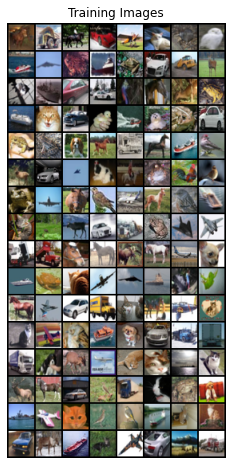

In [ ]:
start = time.time()
dataiter = iter(dataloader)
images,labels = dataiter.next()
print ('Time is {} sec'.format(time.time()-start))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(images.to(device), padding=2, normalize=True).cpu(),(1,2,0)))

print('Shape:', images.shape)
print('Batches in train:', len(dataloader))

In [ ]:
lr = 0.0001
beta_1 = 0.5 
beta_2 = 0.999

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

        
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))

crit  = Critic().to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

gen = gen.apply(weights_init)
crit = crit.apply(weights_init)        

In [ ]:
def gradient_penalty(gradient):
    gradient = gradient.view(len(gradient), -1)
    gradient_norm = gradient.norm(2, dim=1)
    penalty = torch.mean((gradient_norm - 1)**2)
    return penalty


In [ ]:
def get_gen_loss(crit_fake_pred):
    gen_loss = -1. * torch.mean(crit_fake_pred)
    return gen_loss

In [ ]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp
    return crit_loss

In [ ]:
def get_gradient(crit, real, fake, epsilon):
    mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_scores = crit(mixed_images)
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
        
    )[0]
    return gradient

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 32, 32), show_fig=False, epoch=0):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.axis('off')
    plt.imshow(np.transpose(image_grid.cpu(),(1,2,0)))
    if show_fig:
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 0/50 Total Steps:391	Total_Time : 162.600883	Loss_C : 0.331678	Loss_G : 0.144605	Loss_C_Mean : 0.678592	Loss_G_Mean : -0.023917	


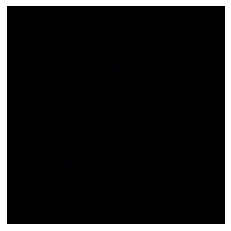

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 1/50 Total Steps:782	Total_Time : 328.830769	Loss_C : -0.852780	Loss_G : 0.444610	Loss_C_Mean : -0.172673	Loss_G_Mean : 0.178260	


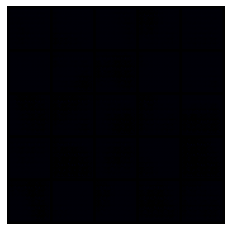

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 2/50 Total Steps:1173	Total_Time : 493.407713	Loss_C : -1.179850	Loss_G : 0.230705	Loss_C_Mean : -1.641379	Loss_G_Mean : 0.483276	


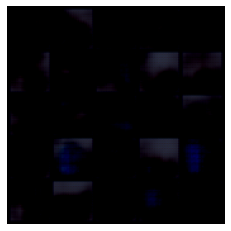

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 3/50 Total Steps:1564	Total_Time : 655.411228	Loss_C : -1.578895	Loss_G : 2.164931	Loss_C_Mean : -1.585483	Loss_G_Mean : 1.086651	


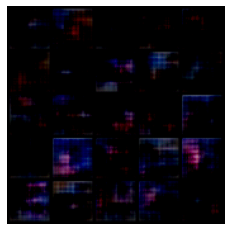

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 4/50 Total Steps:1955	Total_Time : 822.201928	Loss_C : -1.951153	Loss_G : 2.716057	Loss_C_Mean : -1.961563	Loss_G_Mean : 2.714651	


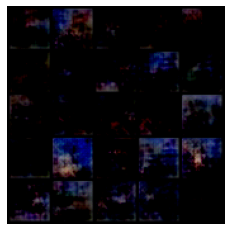

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 5/50 Total Steps:2346	Total_Time : 985.034105	Loss_C : -1.559370	Loss_G : 8.570284	Loss_C_Mean : -1.926087	Loss_G_Mean : 5.389232	


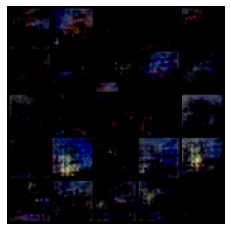

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 6/50 Total Steps:2737	Total_Time : 1152.381266	Loss_C : -1.628850	Loss_G : 12.062865	Loss_C_Mean : -1.946289	Loss_G_Mean : 10.434819	


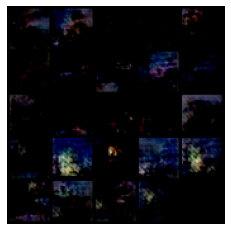

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 7/50 Total Steps:3128	Total_Time : 1314.703014	Loss_C : -3.671673	Loss_G : 12.819816	Loss_C_Mean : -2.006674	Loss_G_Mean : 13.088413	


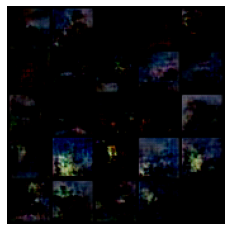

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 8/50 Total Steps:3519	Total_Time : 1482.850539	Loss_C : -2.588802	Loss_G : 11.789229	Loss_C_Mean : -1.923971	Loss_G_Mean : 13.795289	


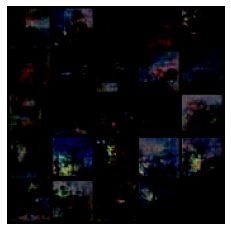

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 9/50 Total Steps:3910	Total_Time : 1645.158092	Loss_C : 0.883001	Loss_G : 13.416049	Loss_C_Mean : -1.888622	Loss_G_Mean : 13.843775	


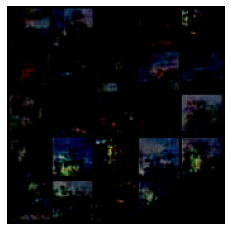

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 10/50 Total Steps:4301	Total_Time : 1808.044739	Loss_C : -2.193272	Loss_G : 13.717807	Loss_C_Mean : -2.006469	Loss_G_Mean : 14.152299	


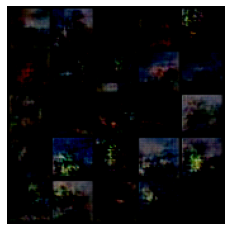

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 11/50 Total Steps:4692	Total_Time : 1970.976812	Loss_C : -3.058081	Loss_G : 14.646327	Loss_C_Mean : -2.196463	Loss_G_Mean : 13.006610	


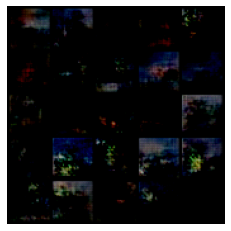

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 12/50 Total Steps:5083	Total_Time : 2134.329494	Loss_C : -2.718049	Loss_G : 8.364050	Loss_C_Mean : -2.515319	Loss_G_Mean : 11.823434	


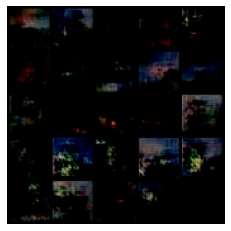

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 13/50 Total Steps:5474	Total_Time : 2298.390456	Loss_C : -2.736279	Loss_G : 8.887901	Loss_C_Mean : -2.093947	Loss_G_Mean : 10.900378	


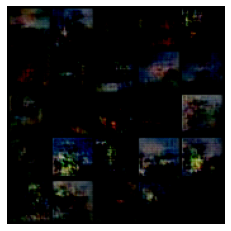

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 14/50 Total Steps:5865	Total_Time : 2462.052713	Loss_C : -2.036487	Loss_G : 10.858422	Loss_C_Mean : -2.441818	Loss_G_Mean : 10.603477	


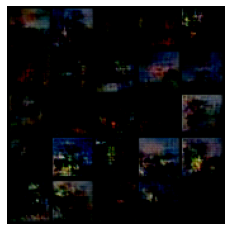

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 15/50 Total Steps:6256	Total_Time : 2625.756733	Loss_C : -3.911119	Loss_G : 7.757493	Loss_C_Mean : -2.392845	Loss_G_Mean : 9.096373	


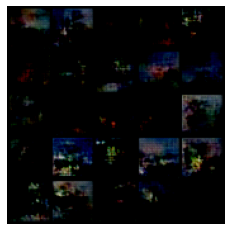

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 16/50 Total Steps:6647	Total_Time : 2789.447747	Loss_C : -3.356171	Loss_G : 7.554901	Loss_C_Mean : -2.655029	Loss_G_Mean : 10.394217	


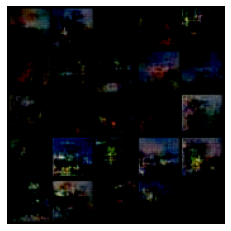

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 17/50 Total Steps:7038	Total_Time : 2953.433431	Loss_C : 5.244801	Loss_G : 12.869100	Loss_C_Mean : -2.091666	Loss_G_Mean : 11.546802	


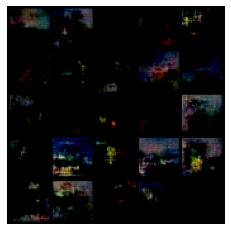

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 18/50 Total Steps:7429	Total_Time : 3117.429147	Loss_C : -2.208579	Loss_G : 10.015310	Loss_C_Mean : -2.665362	Loss_G_Mean : 13.040131	


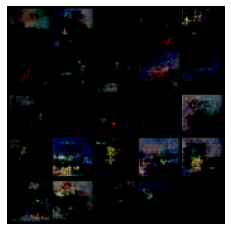

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 19/50 Total Steps:7820	Total_Time : 3281.176529	Loss_C : -3.341899	Loss_G : 11.609450	Loss_C_Mean : -2.590450	Loss_G_Mean : 12.614284	


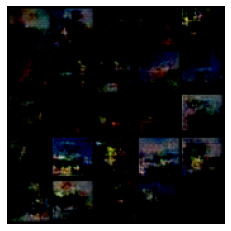

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 20/50 Total Steps:8211	Total_Time : 3445.051437	Loss_C : -3.478235	Loss_G : 10.903019	Loss_C_Mean : -3.151892	Loss_G_Mean : 11.929585	


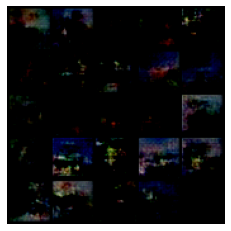

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 21/50 Total Steps:8602	Total_Time : 3609.170247	Loss_C : -4.243474	Loss_G : 14.193034	Loss_C_Mean : -4.516135	Loss_G_Mean : 11.382342	


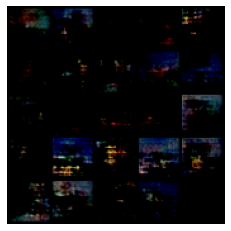

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 22/50 Total Steps:8993	Total_Time : 3773.655870	Loss_C : -1.302623	Loss_G : 14.501297	Loss_C_Mean : -8.357124	Loss_G_Mean : 13.315259	


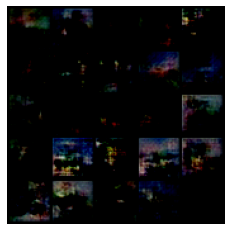

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 23/50 Total Steps:9384	Total_Time : 3937.834209	Loss_C : -1.484984	Loss_G : 14.129440	Loss_C_Mean : -2.938073	Loss_G_Mean : 12.787868	


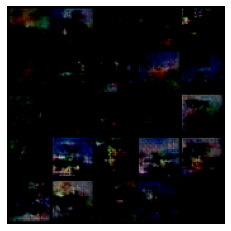

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 24/50 Total Steps:9775	Total_Time : 4101.386350	Loss_C : 1.624696	Loss_G : 13.710914	Loss_C_Mean : -3.620851	Loss_G_Mean : 14.944257	


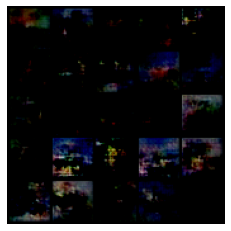

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 25/50 Total Steps:10166	Total_Time : 4266.133768	Loss_C : -9.895874	Loss_G : 22.906315	Loss_C_Mean : -3.888021	Loss_G_Mean : 14.883060	


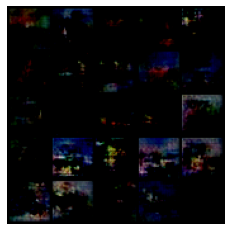

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 26/50 Total Steps:10557	Total_Time : 4430.652774	Loss_C : -8.021772	Loss_G : 24.128275	Loss_C_Mean : -2.898918	Loss_G_Mean : 14.999796	


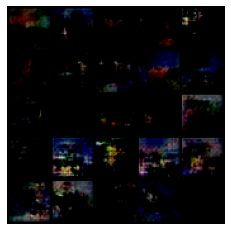

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 27/50 Total Steps:10948	Total_Time : 4595.208178	Loss_C : 5.006599	Loss_G : 13.182871	Loss_C_Mean : -3.716041	Loss_G_Mean : 14.559930	


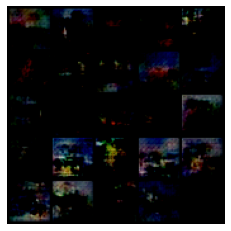

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 28/50 Total Steps:11339	Total_Time : 4759.747956	Loss_C : -8.236423	Loss_G : 20.464643	Loss_C_Mean : -2.649325	Loss_G_Mean : 13.543629	


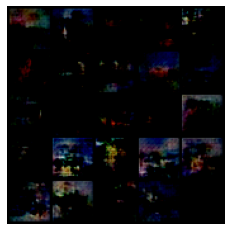

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 29/50 Total Steps:11730	Total_Time : 4924.825681	Loss_C : -5.307315	Loss_G : 18.983667	Loss_C_Mean : -3.759624	Loss_G_Mean : 13.307278	


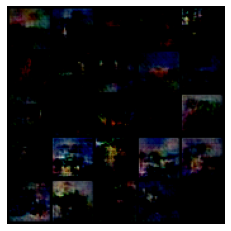

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 30/50 Total Steps:12121	Total_Time : 5090.089600	Loss_C : -9.175808	Loss_G : 7.500623	Loss_C_Mean : -4.645413	Loss_G_Mean : 12.940690	


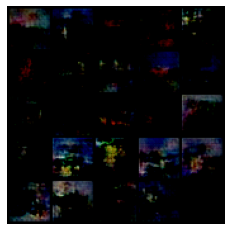

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 31/50 Total Steps:12512	Total_Time : 5255.503531	Loss_C : -6.254123	Loss_G : 3.516634	Loss_C_Mean : -4.873821	Loss_G_Mean : 12.421917	


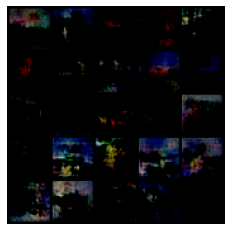

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 32/50 Total Steps:12903	Total_Time : 5421.237335	Loss_C : -2.646144	Loss_G : 14.828891	Loss_C_Mean : -4.974759	Loss_G_Mean : 12.112394	


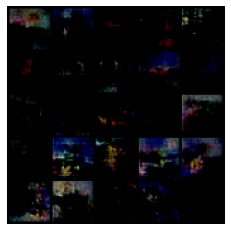

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 33/50 Total Steps:13294	Total_Time : 5587.082108	Loss_C : -9.180221	Loss_G : 11.364776	Loss_C_Mean : -3.681858	Loss_G_Mean : 13.029361	


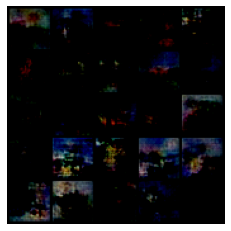

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 34/50 Total Steps:13685	Total_Time : 5752.592624	Loss_C : -35.953961	Loss_G : 19.043669	Loss_C_Mean : -13.060997	Loss_G_Mean : 18.905790	


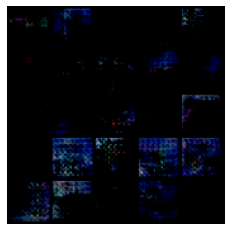

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 35/50 Total Steps:14076	Total_Time : 5918.055387	Loss_C : -8.969342	Loss_G : 15.670386	Loss_C_Mean : -6.614431	Loss_G_Mean : 17.141315	


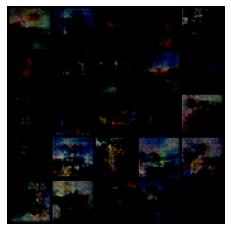

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 36/50 Total Steps:14467	Total_Time : 6084.101157	Loss_C : 11.418310	Loss_G : 2.781871	Loss_C_Mean : -3.959751	Loss_G_Mean : 12.681209	


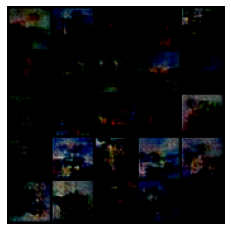

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 37/50 Total Steps:14858	Total_Time : 6250.139575	Loss_C : -0.069839	Loss_G : 11.221782	Loss_C_Mean : -2.455158	Loss_G_Mean : 8.823555	


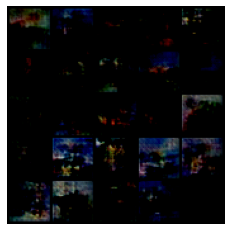

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 38/50 Total Steps:15249	Total_Time : 6416.248345	Loss_C : -7.634801	Loss_G : 13.418117	Loss_C_Mean : -2.771858	Loss_G_Mean : 4.595873	


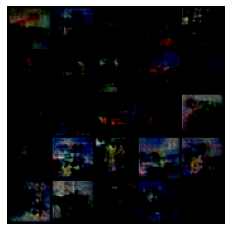

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 39/50 Total Steps:15640	Total_Time : 6582.175353	Loss_C : 2.095150	Loss_G : -2.080025	Loss_C_Mean : -9.733142	Loss_G_Mean : 2.942665	


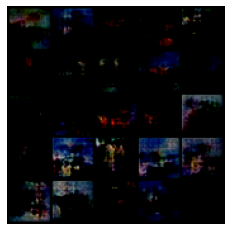

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 40/50 Total Steps:16031	Total_Time : 6748.128430	Loss_C : -6.745418	Loss_G : -7.682494	Loss_C_Mean : -4.253384	Loss_G_Mean : 1.677863	


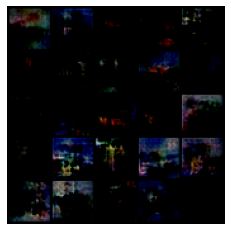

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 41/50 Total Steps:16422	Total_Time : 6914.264184	Loss_C : 0.279585	Loss_G : 6.860479	Loss_C_Mean : -4.413847	Loss_G_Mean : 2.628452	


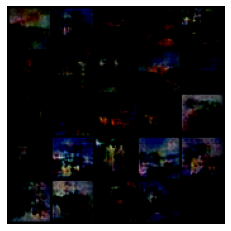

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 42/50 Total Steps:16813	Total_Time : 7080.332919	Loss_C : -1.633282	Loss_G : 7.529270	Loss_C_Mean : -4.160911	Loss_G_Mean : 2.966537	


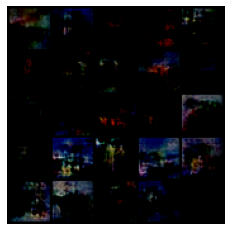

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 43/50 Total Steps:17204	Total_Time : 7246.395015	Loss_C : 0.825336	Loss_G : 2.548903	Loss_C_Mean : -1.944031	Loss_G_Mean : 2.178907	


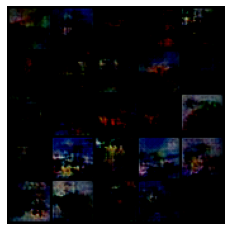

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 44/50 Total Steps:17595	Total_Time : 7412.411715	Loss_C : -57.425397	Loss_G : 2.939383	Loss_C_Mean : -15.508988	Loss_G_Mean : 3.639368	


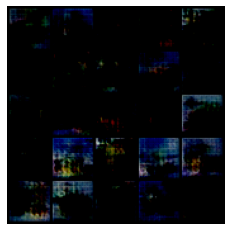

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 45/50 Total Steps:17986	Total_Time : 7578.436820	Loss_C : -18.015882	Loss_G : 14.640021	Loss_C_Mean : -42.611579	Loss_G_Mean : 9.940766	


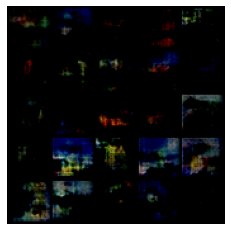

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 46/50 Total Steps:18377	Total_Time : 7744.130865	Loss_C : 2.161835	Loss_G : 4.157015	Loss_C_Mean : -5.905892	Loss_G_Mean : 6.382921	


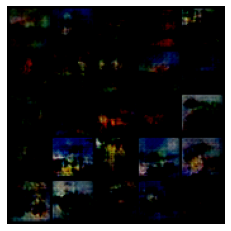

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 47/50 Total Steps:18768	Total_Time : 7909.990665	Loss_C : -0.359805	Loss_G : 9.167735	Loss_C_Mean : -0.995884	Loss_G_Mean : 8.268586	


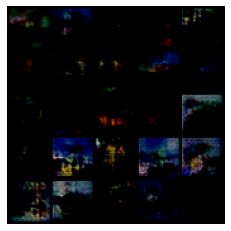

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 48/50 Total Steps:19159	Total_Time : 8076.058846	Loss_C : -0.066131	Loss_G : 12.385924	Loss_C_Mean : -0.236260	Loss_G_Mean : 10.063588	


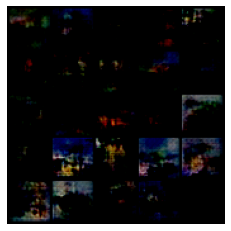

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 49/50 Total Steps:19550	Total_Time : 8242.353151	Loss_C : 0.236000	Loss_G : 5.968572	Loss_C_Mean : -2.097376	Loss_G_Mean : 9.892249	


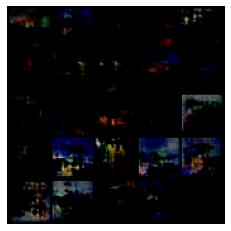

In [ ]:
n_epochs = 50
cur_step = 0
total_steps = 0
start_time = time.time()
cur_step = 0

generator_losses = []
critic_losses = []

C_mean_losses = []
G_mean_losses = []

c_lambda = 10
crit_repeats = 5
display_step = 50

for epoch in range(n_epochs):
    cur_step = 0
    start = time.time()
    for real, _ in dataloader:
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            crit_loss.backward(retain_graph=True)
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        gen_opt.step()

        generator_losses += [gen_loss.item()]
        
        cur_step += 1
        total_steps += 1
        
        print_val = f"Epoch: {epoch}/{n_epochs} Steps:{cur_step}/{len(dataloader)}\t"
        print_val += f"Epoch_Run_Time: {(time.time()-start):.6f}\t"
        print_val += f"Loss_C : {mean_iteration_critic_loss:.6f}\t"
        print_val += f"Loss_G : {gen_loss:.6f}\t"  
        print(print_val, end='\r',flush = True)

    print()
    gen_mean = sum(generator_losses[-cur_step:]) / cur_step
    crit_mean = sum(critic_losses[-cur_step:]) / cur_step
    
    C_mean_losses.append(crit_mean)
    G_mean_losses.append(gen_mean)
    
    print_val = f"Epoch: {epoch}/{n_epochs} Total Steps:{total_steps}\t"
    print_val += f"Total_Time : {(time.time() - start_time):.6f}\t"
    print_val += f"Loss_C : {mean_iteration_critic_loss:.6f}\t"
    print_val += f"Loss_G : {gen_loss:.6f}\t"
    print_val += f"Loss_C_Mean : {crit_mean:.6f}\t"
    print_val += f"Loss_G_Mean : {gen_mean:.6f}\t"
    print(print_val)
    
    fake_noise = fixed_noise
    fake = gen(fake_noise)
    
    show_tensor_images(fake, show_fig=True,epoch=epoch)
    
    cur_step = 0
    

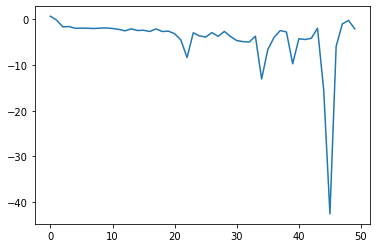

In [ ]:
plt.plot(range(epoch+1),C_mean_losses)


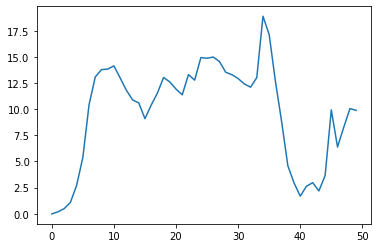

In [ ]:
plt.plot(range(epoch+1),G_mean_losses)
